In [1]:
using LinearAlgebra

# Classical vs. Modified Gram–Schmidt

This is an example adapted from Trefethen and Bau, *Numerical Linear Algebra*, lecture 9.  We construct a square matrix $A$ with exponentially graded singular values between $2^{-1}$ and $2^{-80}$, perform QR factorization in various ways, and check the accuracy and orthogonality of the results.

In [2]:
U = qr(randn(80,80)).Q # U = random 80×80 orthogonal matrix
V = qr(randn(80,80)).Q # V = random 80×80 orthogonal matrix
Σ = Diagonal(2.0 .^ (-1:-1:-80)) # Σ = diagonal matrix with entries 2^-1, 2^-2, ..., 2^-80
A = U * Σ * V'

80×80 Array{Float64,2}:
  0.000231854   0.00268094   -0.00137889  …   0.00808154   0.0021612  
  0.00150013    0.00728824    0.00637139      0.0146435    0.0124736  
 -0.00199683    0.000768221   0.00529652      0.00311741   0.00324461 
 -0.00810116    0.00698248    0.0164884       0.00451867   0.0123352  
 -0.00561649    0.00781266    0.0164853      -0.00156012   0.0143506  
  0.00594206    0.00203292   -0.0068222   …   0.00868233   0.00241761 
  0.00726403   -0.000827504  -0.0114629       0.00913695  -0.00250299 
  0.00842628    0.00809517   -0.00146934      0.0194219    0.013093   
 -0.00474504   -0.000715668   0.00286263     -0.00383209  -0.00254326 
  0.0109184    -0.00125787   -0.00863372      0.00852912   0.000309602
  0.00079431   -0.00580371   -0.00947686  …  -0.00673583  -0.0119864  
 -0.0057927     0.00166188    0.0138113      -0.00735663   0.00581072 
 -0.000204354  -0.00437535   -0.00406131     -0.0138368   -0.00823296 
  ⋮                                       ⋱          

Now, let's implement classical and modified Gram–Schmidt algorithms to return the (reduced) QR factorizations of a matrix A:

In [3]:
# Classical Gram–Schmidt (Trefethen algorithm 7.1), implemented in the simplest way
# (We could make it faster by unrolling loops to avoid temporaries arrays etc.)
function clgs(A)
    m,n = size(A)
    T = float(eltype(A))
    Q = similar(A, T)
    R = zeros(T,n,n)
    @views for j = 1:n
        aⱼ = A[:,j]
        vⱼ = copy(aⱼ) # use copy so that modifying vⱼ doesn't change aⱼ
        for i = 1:j-1
            qᵢ = Q[:,i]
            R[i,j] = dot(qᵢ, aⱼ)
            vⱼ .-= R[i,j] .* qᵢ
        end
        R[j,j] = norm(vⱼ)
        Q[:,j] .= vⱼ ./ R[j,j]
    end
    return Q, R
end

# Modified Gram–Schmidt (Trefethen algorithm 8.1)
function mgs(A)
    m,n = size(A)
    T = float(eltype(A))
    Q = similar(A, T)
    R = zeros(T,n,n)
    @views for j = 1:n
        aⱼ = A[:,j]
        vⱼ = copy(aⱼ)
        for i = 1:j-1
            qᵢ = Q[:,i]
            R[i,j] = dot(qᵢ, vⱼ) # ⟵ NOTICE: mgs has vⱼ, clgs has aⱼ
            vⱼ .-= R[i,j] .* qᵢ
        end
        R[j,j] = norm(vⱼ)
        Q[:,j] .= vⱼ ./ R[j,j]
    end
    return Q, R
end

mgs (generic function with 1 method)

Next, use these on our matrix $A$ from above:

In [4]:
QC, RC = clgs(A);
QM, RM = mgs(A);

Finally, we plot the diagonal elements of $R$, because $r_{jj} = \Vert v_j \Vert$, the norm of the projection of $a_j$ on to the space orthogonal to the previous columns.

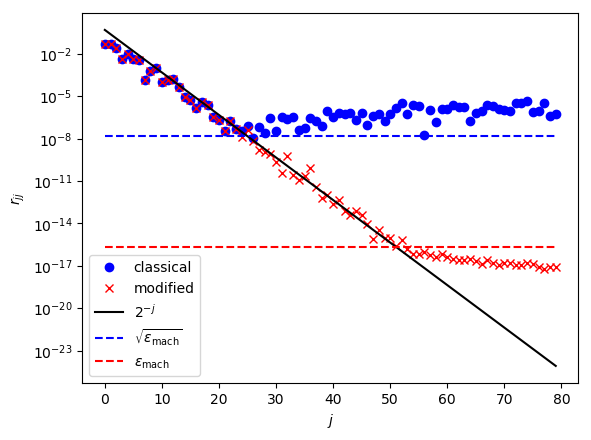

PyObject Text(0.5, 28.0, '$j$')

In [5]:
using PyPlot

n = size(A,2)
semilogy(diag(RC), "bo")
semilogy(diag(RM), "rx")
semilogy(2.0 .^ -(1:n), "k-")
semilogy(fill(sqrt(eps()), n), "b--")
semilogy(fill(eps(), n), "r--")
legend(["classical","modified",L"2^{-j}", L"\sqrt{\epsilon_\mathrm{mach}}", L"\epsilon_\mathrm{mach}"], loc="lower left")
ylabel(L"r_{jj}")
xlabel(L"j")

Note that the errors in classical Gram–Schmidt are at the level of $\sqrt{\epsilon_\mathrm{mach}}$, whereas they are at the level of $\epsilon_\mathrm{mach}$ for modified Gram–Schmidt.  Clearly, the errors are accumulating too fast for stability in the former algorithm.

### Arbitrary-precision Gram–Schmidt

It turns out that the "errors" in the modifed Gram–Schmidt $r_{jj}$ are mainly due to errors in constructing $A$ in the first place (which make `A` less singular than we thought: its actual singular values don't go down to $2^{-80}$), not errors during the Gram–Schmidt process.  We can see this by comparing to a computation in **arbitrary precision** arithmetic via `big` in Julia.  (The default is about 80 decimal places, which is more than sufficient for us here.)  In arbitrary precision, even classical Gram–Schmidt is fine.

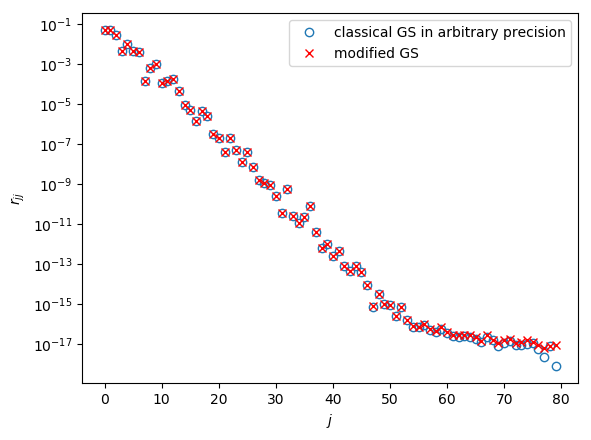

PyObject Text(0.5, 28.0, '$j$')

In [6]:
QCbig, RCbig = clgs(big.(A))

semilogy(Float64.(diag(RCbig)), "o", mfc="none") # convert back to Float64 for plotting, since PyPlot doesn't understand BigFloat
semilogy(diag(RM), "rx")
legend(["classical GS in arbitrary precision","modified GS"], loc="upper right")
ylabel(L"r_{jj}")
xlabel(L"j")

### Orthogonality of $Q$

We can also look at how close $Q$ is to being orthogonal by computing $\Vert Q^*Q - I\Vert_1$:

In [7]:
opnorm(QC'*QC - I, 1), opnorm(QM'*QM - I, 1), opnorm(QCbig'*QCbig - I, 1)

(54.20795533478775, 4.2601255935391515, 4.823914451681306875904673823798277913612754348116138942952074289661034402514632e-37)

Unfortunately, both classical and modified Gram–Schmidt can yield very non-orthogonal $Q$ matrices!   In general, they are *both* unstable as a way to compute $Q$, but the modified Gram–Schmidt algorithm is still useful for least-squares algorithms because $R$ is computed in a backwards-stable way, and the algorithm can be tweaked to solve the least-squares problem $Ax \approx b$ as explained in Trefethen chapter 19.  (The key is to not compute $Q^* b$ via $Q$, but rather by adding $b$ as an additional column of $A$...)

# Householder QR

The `qr` function in Julia (and Matlab and SciPy), in contrast, defaults to using a Householder QR algorithm.  This gives an orthogonal $Q$ matrix and an accurate $R$:

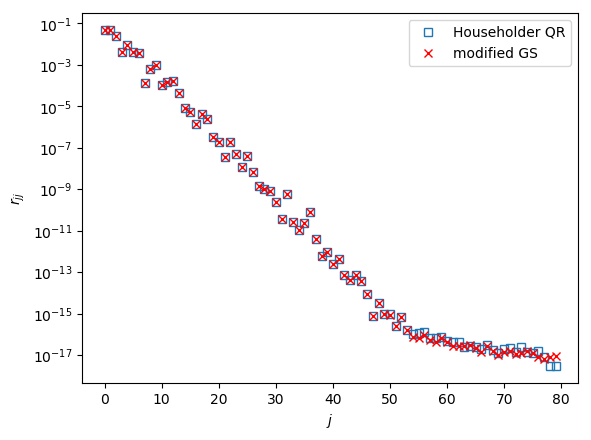

L1 NORM of Householder Q'Q - I: 8.924925279070808e-15


In [8]:
QRH = qr(A)
QH, RH = QRH.Q, QRH.R
semilogy(abs.(diag(RH)), "s", mfc="none") # need abs because householder has arbitrary phase factor in R
semilogy(diag(RM), "rx")
legend(["Householder QR","modified GS"], loc="upper right")
ylabel(L"r_{jj}")
xlabel(L"j")

println("L1 NORM of Householder Q'Q - I: ", opnorm(QH'*QH - I, 1))

On top of that, Householder is faster than Gram–Schmidt, so what's not to love?   But modified Gram–Schmidt is still useful to know since it is the basis of the Arnoldi and GMRES iterative algorithms for large (usually sparse) systems.